In [1]:
%matplotlib inline


# Fitting an image and points

In this example, we will fit a cross onto the same cross, but rotated. We will take advantage of this knowledge and use a rotation deformation module. We will also add some noise on the initial center guess to show how to fit the geometrical descriptors. In addition to images, we add points at the extremity of each branch that will also get matched in order to illustrate multi deformables matching. This also helps the fitting process by adding more information to the model.




Import relevant modules.




In [16]:
import sys
sys.path.append("../")

import math

import torch
import matplotlib.pyplot as plt
import scipy.ndimage

import imodal

imodal.Utilities.set_compute_backend('torch')

Load image data and generate dots.




In [17]:
source_image = imodal.Utilities.load_greyscale_image("../data/images/cross_+_30.png", origin='lower')
target_image = imodal.Utilities.load_greyscale_image("../data/images/cross_+.png", origin='lower')

# Smoothing

extent_length = 31.
extent = imodal.Utilities.AABB(0., extent_length, 0., extent_length)

dots = torch.tensor([[0., 0.5],
                     [0.5, 0.],
                     [0., -0.5],
                     [-0.5, 0.]])

source_dots = 0.6*extent_length*imodal.Utilities.linear_transform(dots, imodal.Utilities.rot2d(math.pi/3)) + extent_length*torch.tensor([0.5, 0.5])

target_dots = 0.6*extent_length*imodal.Utilities.linear_transform(dots, imodal.Utilities.rot2d(math.pi/1)) + extent_length*torch.tensor([0.5, 0.5])

center = extent_length*torch.tensor([[0.3, 0.1]])

Plot everything.




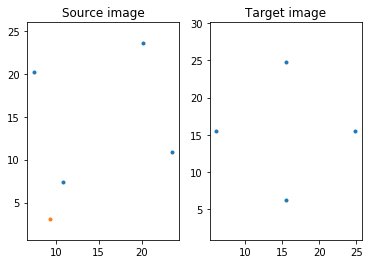

In [18]:
plt.subplot(1, 2, 1)
plt.title("Source image")
#plt.imshow(source_image, origin='lower', extent=extent.totuple())
plt.plot(source_dots.numpy()[:, 0], source_dots.numpy()[:, 1], '.')
plt.plot(center.numpy()[:, 0], center.numpy()[:, 1], '.')
plt.axis('equal')
plt.subplot(1, 2, 2)
plt.title("Target image")
#plt.imshow(target_image, origin='lower', extent=extent.totuple())
plt.plot(target_dots.numpy()[:, 0], target_dots.numpy()[:, 1], '.')
plt.axis('equal')

plt.show()

We know that the target cross is the result of some rotation at its origin,
so we use a local rotation deformation module, with an imprecise center
position to simulate data aquisition noise.




In [19]:
rotation = imodal.DeformationModules.LocalRotation(2, 2.*extent_length, gd=center)

Create the model by setting `True` for `fit_gd` so that it also optimize the
rotation center.




In [20]:
#source_deformable = imodal.Models.DeformableImage(source_image, output='bitmap', extent='match', backward=True)
#target_deformable = imodal.Models.DeformableImage(target_image, output='bitmap', extent='match', backward=True)

source_dots_deformable = imodal.Models.DeformablePoints(source_dots)
target_dots_deformable = imodal.Models.DeformablePoints(target_dots)

#attachment = imodal.Attachment.L2NormAttachment(transform=None)

model = imodal.Models.RegistrationModel([source_dots_deformable], [rotation], [imodal.Attachment.EuclideanPointwiseDistanceAttachment()], fit_gd=[True], lam=200.)

Fit the model.




In [21]:
shoot_solver = 'rk4'
shoot_it = 10
max_it = 100

costs = {}
fitter = imodal.Models.Fitter(model, optimizer='torch_lbfgs')

fitter.fit([target_dots_deformable], max_it, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})

Starting optimization with method torch LBFGS, using solver rk4 with 10 iterations.
Initial cost={'deformation': 0.0, 'attach': 12886.4580078125}
1e-10
Evaluated model with costs=12886.4580078125
Evaluated model with costs=12880.572715638205
Evaluated model with costs=12828.785237789154
Evaluated model with costs=12430.342750549316
Evaluated model with costs=15625.200927734375
Evaluated model with costs=12406.780746459961
Evaluated model with costs=12249.344299316406
Evaluated model with costs=12657.564292907715
Evaluated model with costs=12169.866928100586
Evaluated model with costs=12091.039306640625
Evaluated model with costs=12256.200927734375
Evaluated model with costs=11915.168579101562
Evaluated model with costs=11738.925048828125
Evaluated model with costs=11706.600952148438
Evaluated model with costs=11664.220092773438
Evaluated model with costs=11611.296264648438
Evaluated model with costs=11568.364379882812
Evaluated model with costs=11549.138916015625
Evaluated model with c

Plot total cost evolution.




Compute the final deformed source and plot it.




Fitted rotatation center: [[15.433380126953125, 15.44064998626709]]


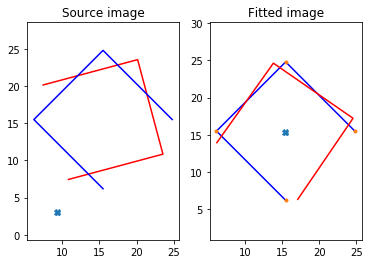

In [22]:
with torch.autograd.no_grad():
    model.deformables[0].output = 'bitmap'
    deformed = model.compute_deformed(shoot_solver, shoot_it)

    #deformed_image = deformed[0][0].view_as(source_image)
    deformed_dots = deformed[0][0]

fitted_center = model.init_manifold[1].gd.detach()

print("Fitted rotatation center: {center}".format(center=fitted_center.detach().tolist()))

plt.subplot(1, 2, 1)
plt.title("Source image")
#plt.imshow(source_image.numpy(), origin='lower', extent=extent.totuple())
plt.plot(source_dots.numpy()[:, 0], source_dots.numpy()[:, 1], 'r')
plt.plot(target_dots.numpy()[:, 0], target_dots.numpy()[:, 1], 'b')
plt.plot(center.numpy()[0, 0], center.numpy()[0, 1], 'X')
plt.axis('equal')
#plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Fitted image")
#plt.imshow(deformed_image.numpy(), origin='lower', extent=extent.totuple())
#plt.plot(source_dots.numpy()[:, 0], source_dots.numpy()[:, 1], 'g')
plt.plot(target_dots.numpy()[:, 0], target_dots.numpy()[:, 1], 'b')
plt.plot(deformed_dots.numpy()[:, 0], deformed_dots.numpy()[:, 1], 'r')
plt.plot(fitted_center.numpy()[0, 0], fitted_center.numpy()[0, 1], 'X')
plt.plot(target_dots.numpy()[:, 0], target_dots.numpy()[:, 1], '.')
plt.axis('equal')
#plt.axis('off')

plt.show()

In [13]:
with torch.autograd.no_grad():
    intermediates = {}
    model.deformables[0].output = 'bitmap'
    deformed = model.compute_deformed(shoot_solver, shoot_it, intermediates=intermediates)

    #deformed_image = deformed[0][0].view_as(source_image)
    deformed_dots = deformed[0][0]


In [16]:
intermediates['states'][0].gd[0]

tensor([[ 7.4460, 20.1500],
        [20.1500, 23.5540],
        [23.5540, 10.8500],
        [10.8500,  7.4460]])

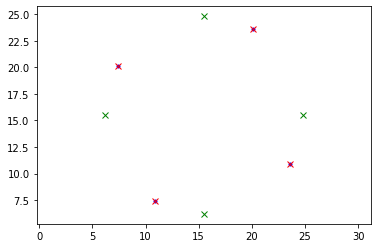

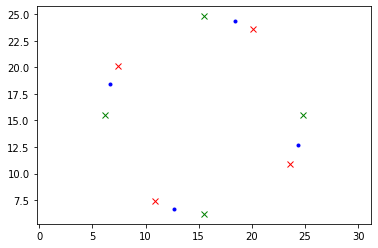

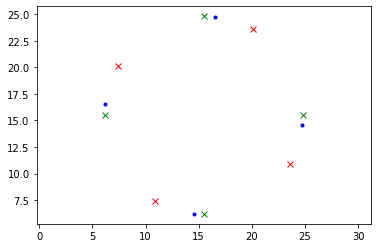

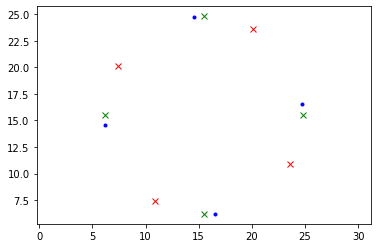

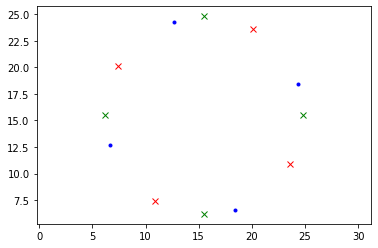

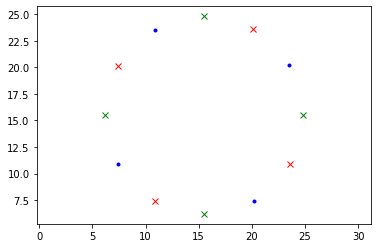

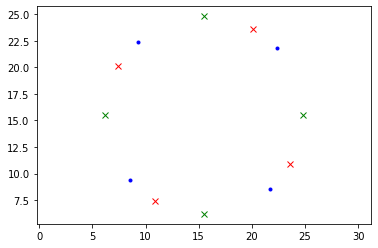

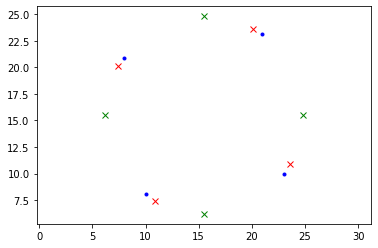

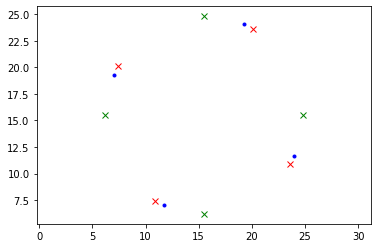

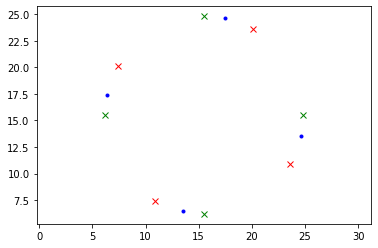

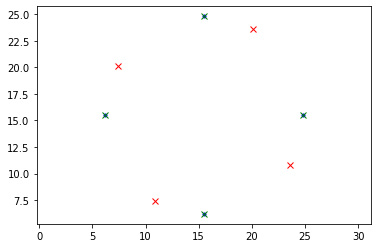

In [23]:

for state in intermediates['states']:
    plt.figure()
    pts = state.gd[0]
    plt.plot(pts[:,0].detach(), pts[:,1].detach(), '.b')
    plt.plot(source_dots.numpy()[:, 0], source_dots.numpy()[:, 1], 'xr')
    plt.plot(target_dots.numpy()[:, 0], target_dots.numpy()[:, 1], 'xg')
    plt.axis('equal')